In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, make_scorer
from pathlib import Path
import pickle

import xgboost as xgb

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 8)

In [2]:
df = pd.read_csv("../data/Air Temperature Fix.csv", index_col='datetime', parse_dates=True)
df

,airTemperature
datetime,
2024-11-01 10:21:00+00:00,26.55
2024-11-01 10:22:00+00:00,26.60
2024-11-01 10:23:00+00:00,26.60
2024-11-01 10:24:00+00:00,26.65
2024-11-01 10:25:00+00:00,26.70
...,...
2024-11-24 12:23:00+00:00,27.81
2024-11-24 12:24:00+00:00,27.80
2024-11-24 12:25:00+00:00,27.80


In [3]:
df = df.asfreq("1min")
df.index

DatetimeIndex(['2024-11-01 10:21:00+00:00', '2024-11-01 10:22:00+00:00',
               '2024-11-01 10:23:00+00:00', '2024-11-01 10:24:00+00:00',
               '2024-11-01 10:25:00+00:00', '2024-11-01 10:26:00+00:00',
               '2024-11-01 10:27:00+00:00', '2024-11-01 10:28:00+00:00',
               '2024-11-01 10:29:00+00:00', '2024-11-01 10:30:00+00:00',
               ...
               '2024-11-24 12:18:00+00:00', '2024-11-24 12:19:00+00:00',
               '2024-11-24 12:20:00+00:00', '2024-11-24 12:21:00+00:00',
               '2024-11-24 12:22:00+00:00', '2024-11-24 12:23:00+00:00',
               '2024-11-24 12:24:00+00:00', '2024-11-24 12:25:00+00:00',
               '2024-11-24 12:26:00+00:00', '2024-11-24 12:27:00+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=33247, freq='min')

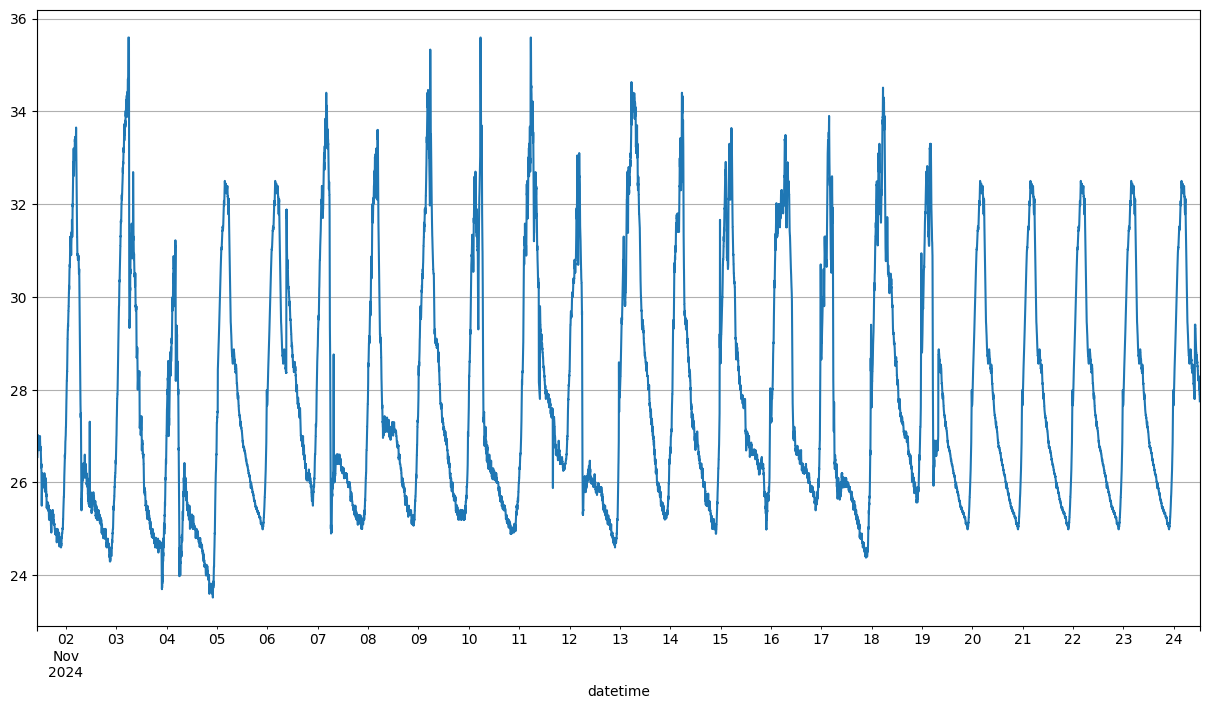

In [4]:
fig, ax = plt.subplots()
df['airTemperature'].plot(ax=ax)
plt.grid()
plt.show()

In [5]:
print(f'Number data NaN\t: {df.isna().sum()}')

Number data NaN	: airTemperature    0
dtype: int64


In [6]:
def create_features(dataframe):
    data = dataframe.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['minute'] = data.index.minute
    data['dayofyear'] = data.index.dayofyear
    data['dayofweek'] = data.index.dayofweek

    return data

df_cf = create_features(df)
df_cf

,airTemperature,year,month,day,hour,minute,dayofyear,dayofweek
datetime,,,,,,,,
2024-11-01 10:21:00+00:00,26.55,2024,11,1,10,21,306,4
2024-11-01 10:22:00+00:00,26.60,2024,11,1,10,22,306,4
2024-11-01 10:23:00+00:00,26.60,2024,11,1,10,23,306,4
2024-11-01 10:24:00+00:00,26.65,2024,11,1,10,24,306,4
2024-11-01 10:25:00+00:00,26.70,2024,11,1,10,25,306,4
...,...,...,...,...,...,...,...,...
2024-11-24 12:23:00+00:00,27.81,2024,11,24,12,23,329,6
2024-11-24 12:24:00+00:00,27.80,2024,11,24,12,24,329,6
2024-11-24 12:25:00+00:00,27.80,2024,11,24,12,25,329,6


In [7]:
X, y = df_cf.drop(columns=['airTemperature']), df_cf[['airTemperature']]
print(f'Number data used: {X.shape}')

Number data used: (33247, 7)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
print(f'Number data training: {X_train.shape[0]}')
print(f'Number data test: {X_test.shape[0]}')

Number data training: 23272
Number data test: 9975


In [9]:
model = xgb.XGBRegressor(
    n_estimators=2500,
    learning_rate= 0.01,
    max_depth= 3,
    subsample= 1.0,
    colsample_bytree= 1.0,
    gamma= 0,
    reg_alpha= 1,
    reg_lambda= 2
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
filepath = Path('model/XGBoost_airTemperature.pkl')
filepath.parent.mkdir(parents=True, exist_ok=True)
pickle.dump(model, open(filepath, 'wb'))

In [11]:
loaded_model = pickle.load(open(filepath, 'rb'))

In [12]:
y_test['prediction'] = loaded_model.predict(X_test)
y_test

,airTemperature,prediction
datetime,,
2024-11-17 14:13:00+00:00,25.72,25.556578
2024-11-17 14:14:00+00:00,25.76,25.553635
2024-11-17 14:15:00+00:00,25.71,25.543465
2024-11-17 14:16:00+00:00,25.67,25.535007
2024-11-17 14:17:00+00:00,25.64,25.533535
...,...,...
2024-11-24 12:23:00+00:00,27.81,25.807283
2024-11-24 12:24:00+00:00,27.80,25.802649
2024-11-24 12:25:00+00:00,27.80,25.802649


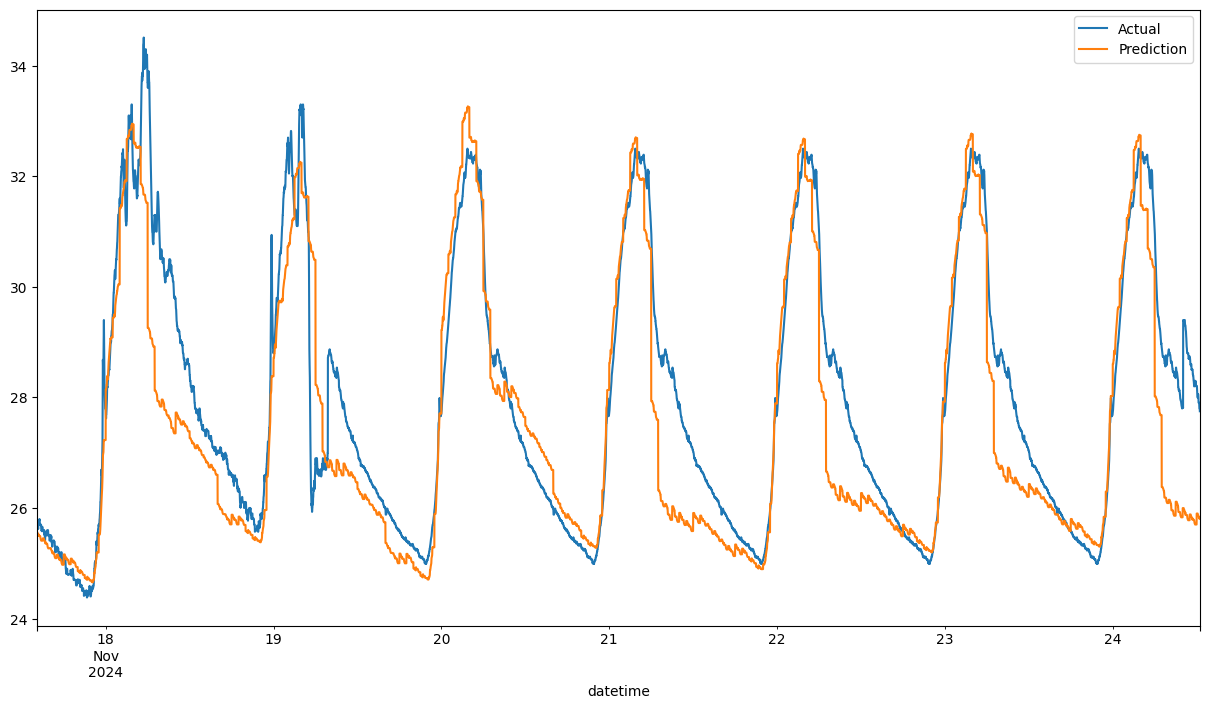

In [13]:
fig, ax = plt.subplots()
y_test['airTemperature'].plot(ax=ax)
y_test['prediction'].plot(ax=ax)
plt.legend(['Actual', 'Prediction'])
plt.show()

In [14]:
mae = mean_absolute_error(y_test['airTemperature'], y_test['prediction'])
mape = mean_absolute_percentage_error(y_test['airTemperature'], y_test['prediction'])
rmse = root_mean_squared_error(y_test['airTemperature'], y_test['prediction'])

print(f'''
mae\t: {mae}
mape\t: {mape}
rmse\t: {rmse}
''')


mae	: 0.7876808326510857
mape	: 0.02756511212670133
rmse	: 1.1173785316874765



In [15]:
startdate = df.index[-1] + pd.Timedelta(minutes=1)
datetime = pd.date_range(start=startdate, periods=(60 * 24), freq="min")

In [16]:
df_future = pd.DataFrame({'datetime': datetime})
df_future = df_future.set_index('datetime')
df_future = create_features(df_future)

In [17]:
df_future['prediction_airTemperature'] = loaded_model.predict(df_future)
df_future

,year,month,day,hour,minute,dayofyear,dayofweek,prediction_airTemperature
datetime,,,,,,,,
2024-11-24 12:28:00+00:00,2024,11,24,12,28,329,6,25.804193
2024-11-24 12:29:00+00:00,2024,11,24,12,29,329,6,25.804193
2024-11-24 12:30:00+00:00,2024,11,24,12,30,329,6,25.804193
2024-11-24 12:31:00+00:00,2024,11,24,12,31,329,6,25.804193
2024-11-24 12:32:00+00:00,2024,11,24,12,32,329,6,25.804193
...,...,...,...,...,...,...,...,...
2024-11-25 12:23:00+00:00,2024,11,25,12,23,330,0,27.170614
2024-11-25 12:24:00+00:00,2024,11,25,12,24,330,0,27.165979
2024-11-25 12:25:00+00:00,2024,11,25,12,25,330,0,27.165979


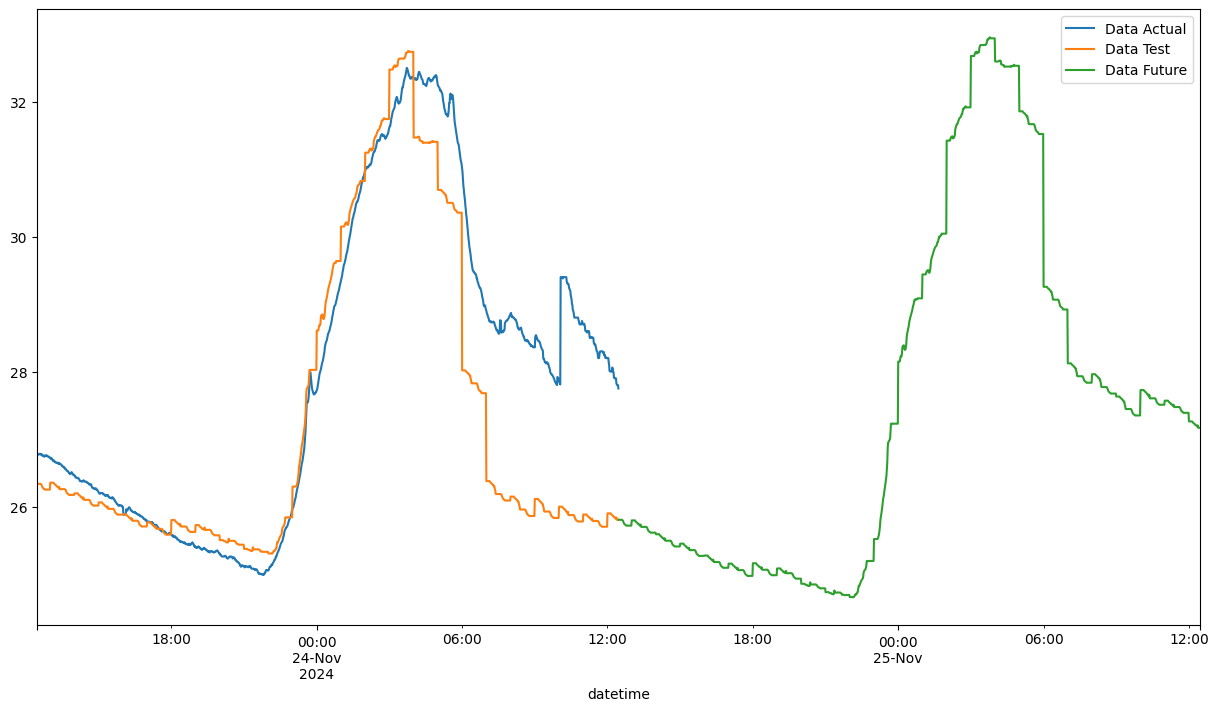

In [18]:
fig, ax = plt.subplots()
df[['airTemperature']].iloc[-(60 * 24):].plot(ax=ax)
y_test[['prediction']].iloc[-(60 * 24):].plot(ax=ax)
df_future['prediction_airTemperature'].plot(ax=ax)
plt.legend(['Data Actual', 'Data Test', 'Data Future'])
plt.show()